In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from scipy.stats import pearsonr
from collections import Counter

import warnings
warnings.filterwarnings("ignore")
pd.options.mode.chained_assignment = None

# Load and preliminary steps

In [2]:
dataset_genre = pd.read_json("database_genres_classification.json")
dataset_genre = dataset_genre.sort_index(axis=0)

In [3]:
dataset_genre.head(5)

,track_id,title_billboard,artist_billboard,title_spotify,artist_spotify,key,time_signature,mode,tempo,loudness,...,energy,valence,genre_list,weeks_list,ranks_list,highest_rank,weeks_on_chart,year,genre_main,main_genre
0,6RkUeQHTyqeqnqIygrqnt7,La Paloma,Billy Vaughn And His Orchestra,La Paloma,Billy Vaughn,0,4,1,108.158,-12.301,...,0.3220,0.502,ballroom,[1958-08-08],[92],92,1,1958,None,other
1,6eCsRg7OBi1zT2CEKKyoXN,Fever,Peggy Lee,Fever - Remastered,Peggy Lee,7,4,1,68.331,-21.305,...,0.0715,0.333,big band,[1958-08-08],[13],13,1,1958,None,other
2,4FrMb1ckGBrhARbHySQKx5,Devoted To You,The Everly Brothers,Devoted to You,The Everly Brothers,3,4,1,90.523,-9.387,...,0.3400,0.526,brill building pop,[1958-08-08],[43],43,1,1958,pop,pop
3,2ieO6C3dUH2LajM2wSOJfe,The Wizard,Jimmie Rodgers,The Wizard,Jimmie Rodgers,3,4,0,118.888,-10.720,...,0.5960,0.906,cowboy western,[1958-08-08],[85],85,1,1958,country,other
4,6MV23t3HuEmNR9NmdSI6Ny,The Morning Side Of The Mountain,Tommy Edwards,The Morning Side Of The Mountain,Tommy Edwards,0,3,1,78.462,-12.623,...,0.2990,0.520,deep adult standards,"[1959-03-01, 1959-03-08, 1959-03-15, 1959-03-2...","[93, , 79, , 47, , 32, , 27, , 31, ...",,21,1959,adult standards,other


In [4]:
years_list = []

for ind, item in dataset_genre['weeks_list'].iteritems():
    occurences = [] 
    
    for week in item:
        year = week[:4]
        if not(year in occurences):
            occurences.append(year)
            
    years_list.append(occurences)
    
dataset_genre['years_list'] = years_list

In [5]:
all_years2 = []

for ind, item in dataset_genre['years_list'].iteritems():
    for year in item:
        all_years2.append(year)
        
years2 = pd.Series(all_years2).value_counts().index

In [6]:
years2 = sorted(years2)[1:]

In [7]:
yearly_features2 = {'loudness': [], 'duration_ms': [], 'tempo': [], 'energy': [], 'valence': []}

In [8]:
#Genres we decided to keep
genres = ['pop', 'rock', 'folk', 'jazz', 'country', 'r&b and soul']

# Functions

In [9]:
def make_dataframe_per_genre(feature):
    df_ = pd.DataFrame(columns=genres)
    for genre in genres:
        df = dataset_genre.loc[dataset_genre['main_genre'] == genre]
        feature_per_genre = []
        for year in years2:
            df2 = df.loc[df['year'] == int(year)]
            temp = df2.loc[:, feature]
            if(len(temp) > 0):
                #remove values that represent missing values
                if(feature == 'energy' or feature == 'valence' or feature == 'duration_ms' or feature == 'loudness'):
                    a = list(filter(lambda x: x!= -1, temp.tolist()))
                    feature_per_genre.append(a)
                elif(feature == 'tempo'):
                    a = list(filter(lambda x: x!= 0, temp.tolist()))
                    b = list(filter(lambda x: x!= -1, a))
                    feature_per_genre.append(b)
                else:
                    feature_per_genre.append(temp.tolist())
            else:
                feature_per_genre.append([])
        df_[genre] = feature_per_genre
    df_['year'] = years2
    return df_

In [10]:
def mean_confidence_interval(data, confidence = 0.95):
    
    a = np.array(data)
    if(len(a) > 0):
        n = len(a)
        m, se = np.mean(a), scipy.stats.sem(a)
        h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    else:
        return np.nan, np.nan, np.nan
    return m, m-h, m+h

In [11]:
def compute_bounds(features):
    
    lower_bound, mean, upper_bound = [], [], []

    # Compute the 95% confidence interval
    for list_ in features:
        m, lb, ub = mean_confidence_interval(list_)
    
        lower_bound.append(lb)
        mean.append(m)
        upper_bound.append(ub)
        
    return lower_bound, mean, upper_bound

In [12]:
def plot_by_genre(df, title, min_, max_, savefig):
    # libraries and data
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd

 
    # Initialize the figure
    plt.style.use('seaborn-darkgrid')
    plt.figure(figsize=(30, 10))
 
    # create a color palette
    color = 'b'
 
    # multiple line plot
    num=0
    for column in df.drop('year', axis=1):
        num+=1
 
        # Find the right spot on the plot
        plt.subplot(3,3, num)
 
        # Plot the lineplot
        lower_bound, mean, upper_bound = compute_bounds(df[column].tolist())
        plt.fill_between(range(len(mean)), upper_bound, lower_bound, color = color, alpha = .3)
        plt.plot(df['year'], mean, color)

 
        # Not ticks everywhere
        if num in range(4) :
            plt.tick_params(labelbottom='off')
        if num not in [1,4] :
            plt.tick_params(labelleft='off')
            
        years = []
        for y in df['year']:
            if int(y)%5 == 0:
                years.append(y)
            else:
                years.append(' ')
        
        plt.xticks(years, rotation='vertical', fontsize=13)
        
 
        # Add title
        plt.title(column, loc='left', fontsize=15, color=color)
    
    # Same limits for everybody!
    #plt.xlim(1900, 2000)
    #print(mean, max_, min_)
        plt.ylim(min_, max_)
        plt.yticks(fontsize=13)

 
    # general title
    plt.suptitle(title + " change by year", fontsize=20, fontweight=0, color='black', y=0.97)
    plt.savefig(savefig)

In [13]:
def plot_scatter_plot(x, y, title, ylabel, savefig):
    plt.figure(figsize=(20, 10))
    for xe, ye in zip(x, y):
        plt.scatter([xe] * len(ye), ye, s=10**2, color='b', alpha=0.3)
    plt.xticks(rotation='vertical', fontsize=15)
    plt.xlabel('Years', fontsize=17)
    plt.ylabel(ylabel, fontsize=17)
    plt.yticks(fontsize=15)
    plt.title(title, fontsize=21)
    plt.savefig(savefig)
    plt.show()

# Continuous features by genre 

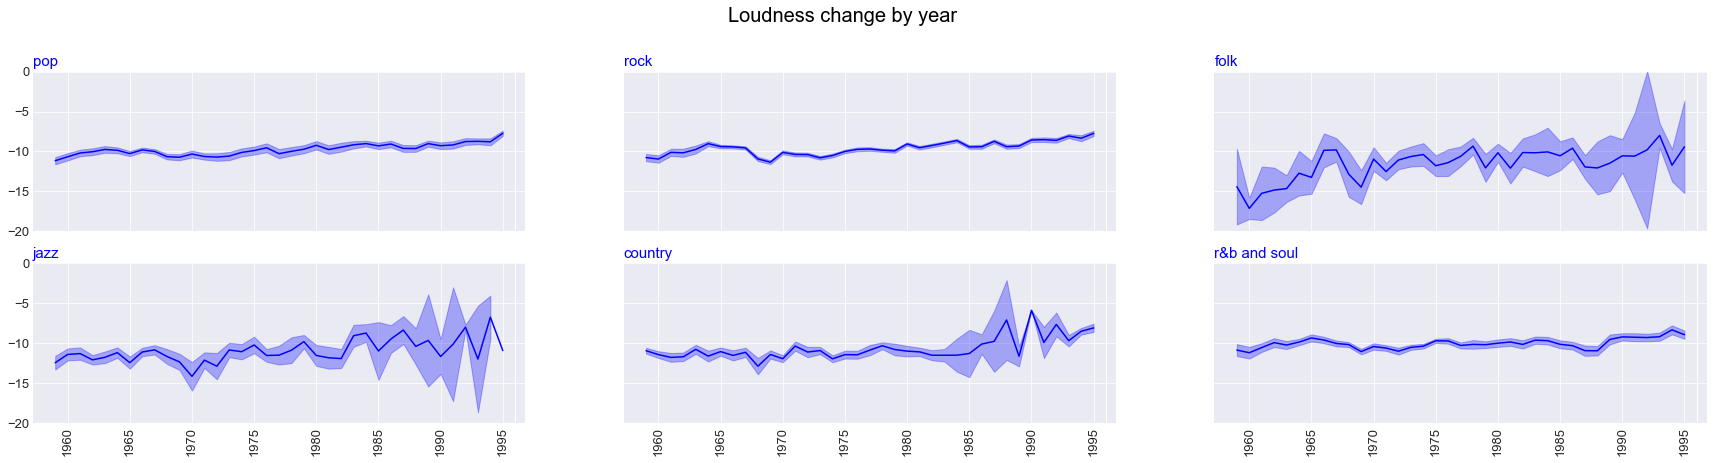

In [14]:
df_ = make_dataframe_per_genre('loudness')
plot_by_genre(df_, 'Loudness', -20, 0, 'loudness_by_genre.png')

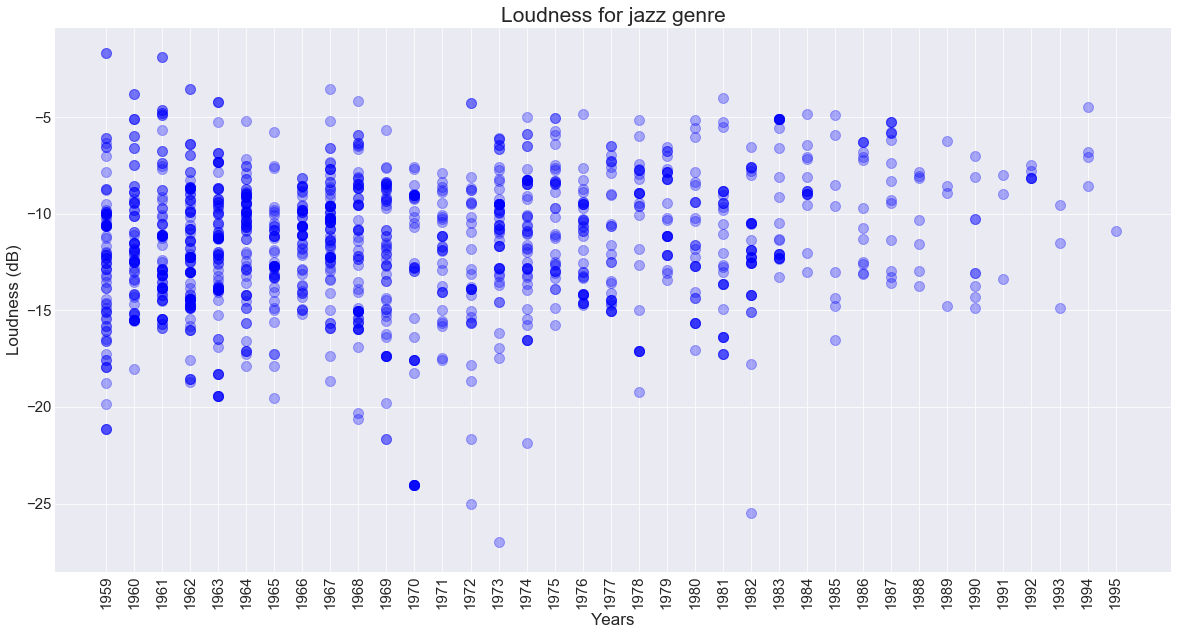

In [15]:
plot_scatter_plot(df_['year'], df_['jazz'], 'Loudness for jazz genre', 'Loudness (dB)', 'loudness_jazz.png')

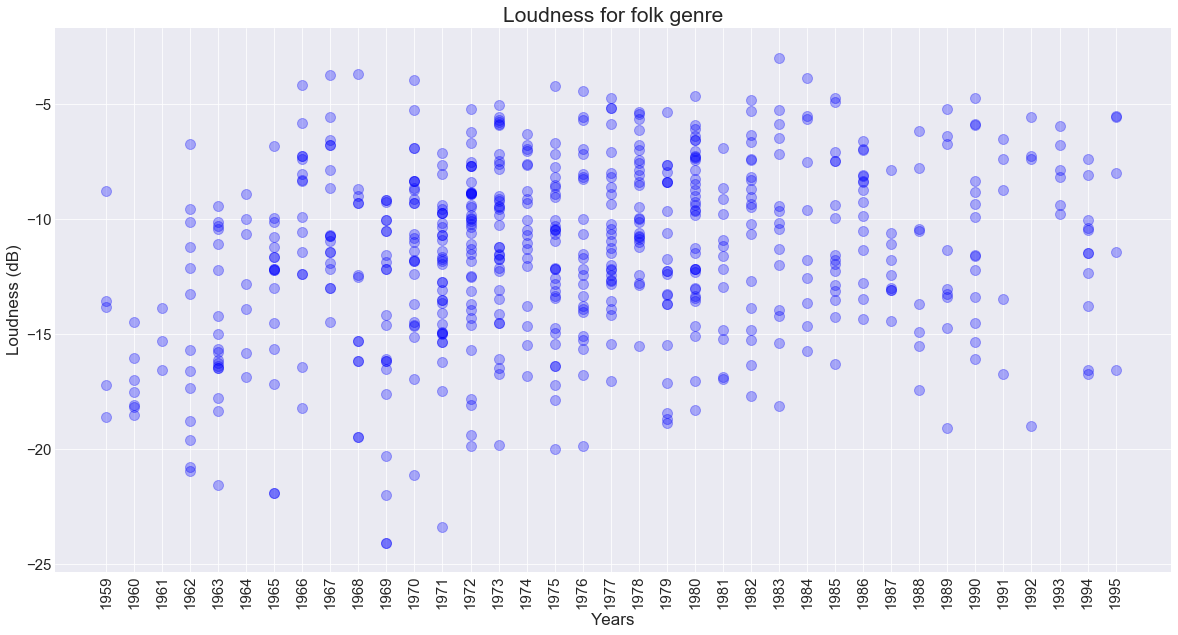

In [16]:
plot_scatter_plot(df_['year'], df_['folk'], 'Loudness for folk genre', 'Loudness (dB)', 'loudness_folk.png')

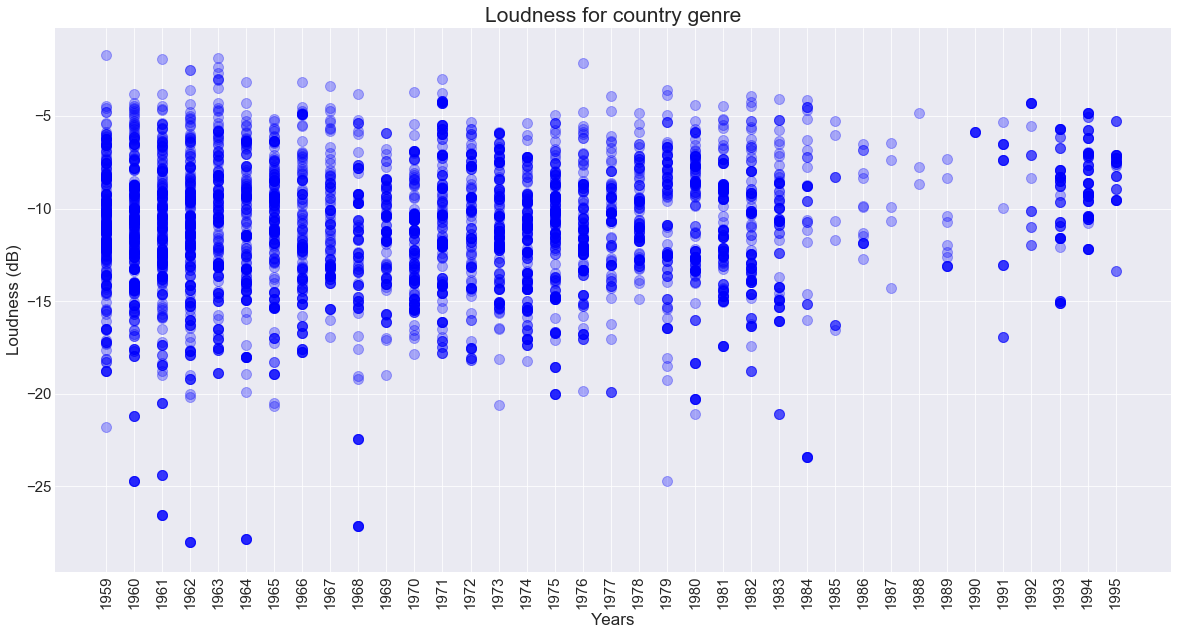

In [17]:
plot_scatter_plot(df_['year'], df_['country'], 'Loudness for country genre', 'Loudness (dB)', 'loudness_country.png')

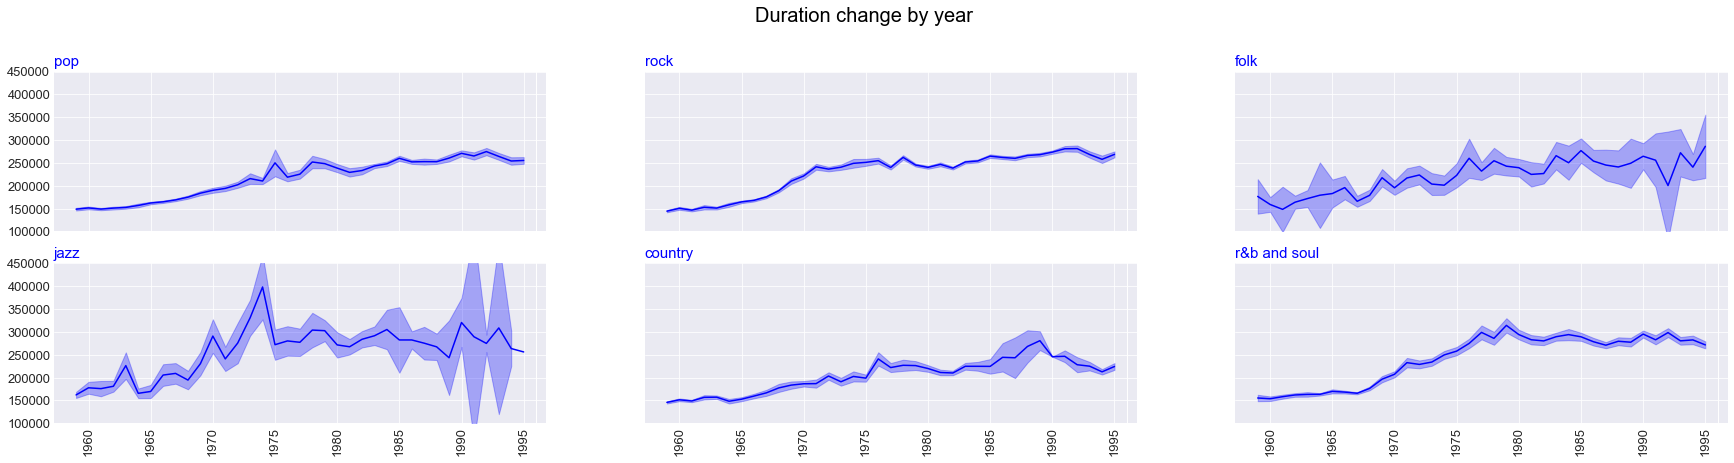

In [18]:
df_ = make_dataframe_per_genre('duration_ms')
plot_by_genre(df_, 'Duration', 100000, 450000, 'duration_by_genre.png')

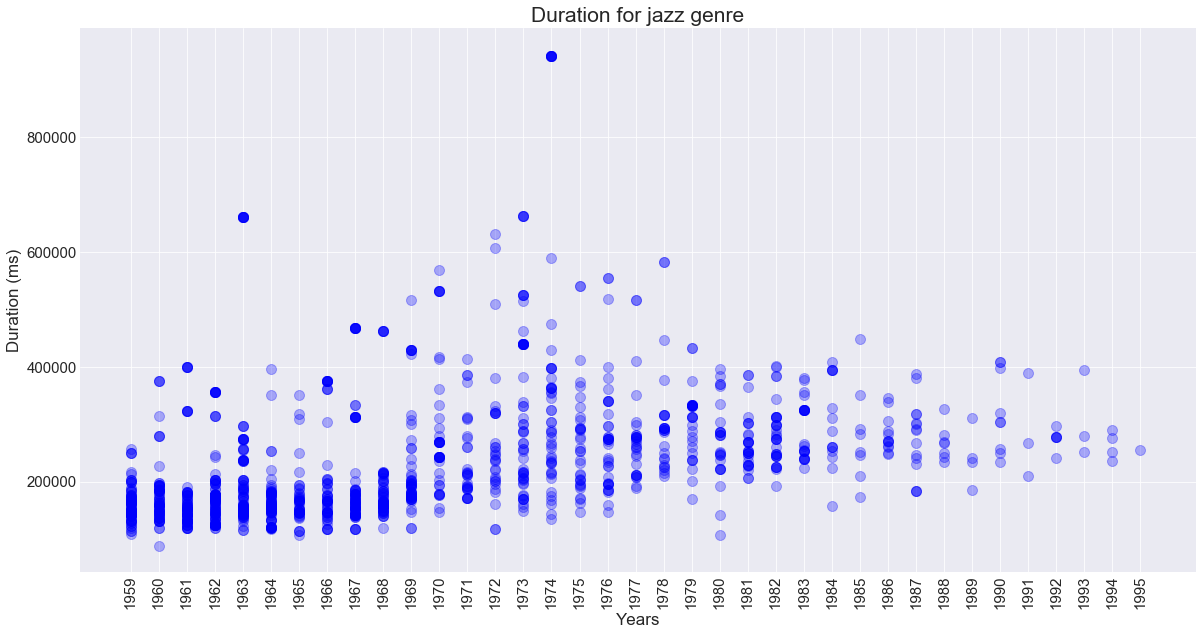

In [19]:
plot_scatter_plot(df_['year'], df_['jazz'], 'Duration for jazz genre', 'Duration (ms)', 'duration_jazz.png')

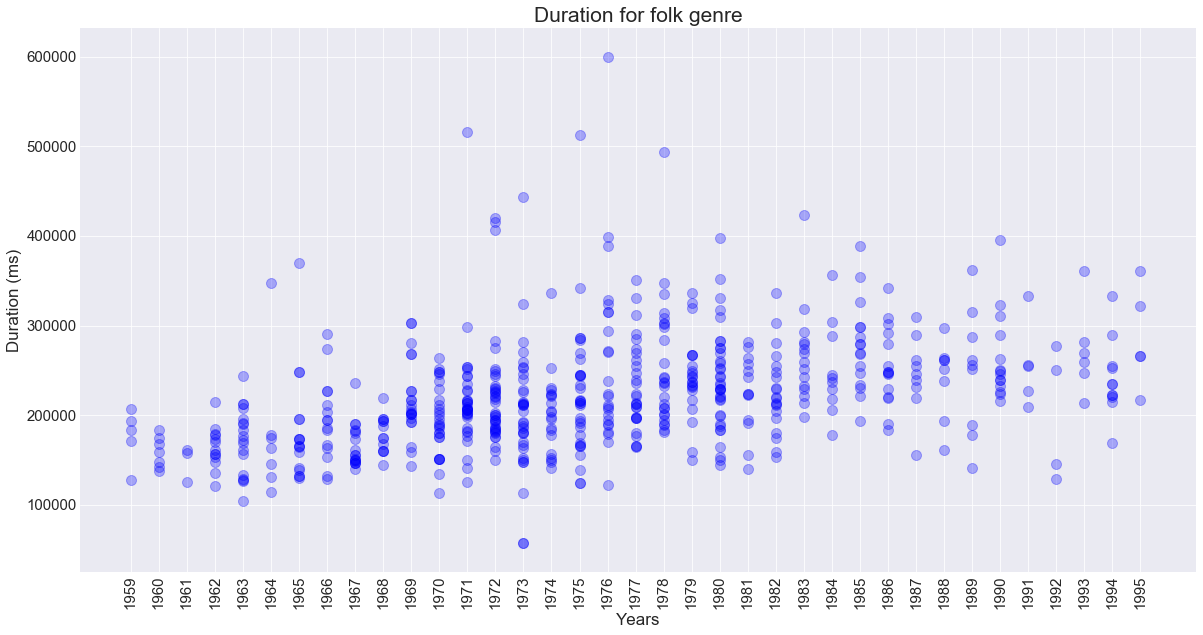

In [20]:
plot_scatter_plot(df_['year'], df_['folk'], 'Duration for folk genre', 'Duration (ms)', 'duration_folk.png')

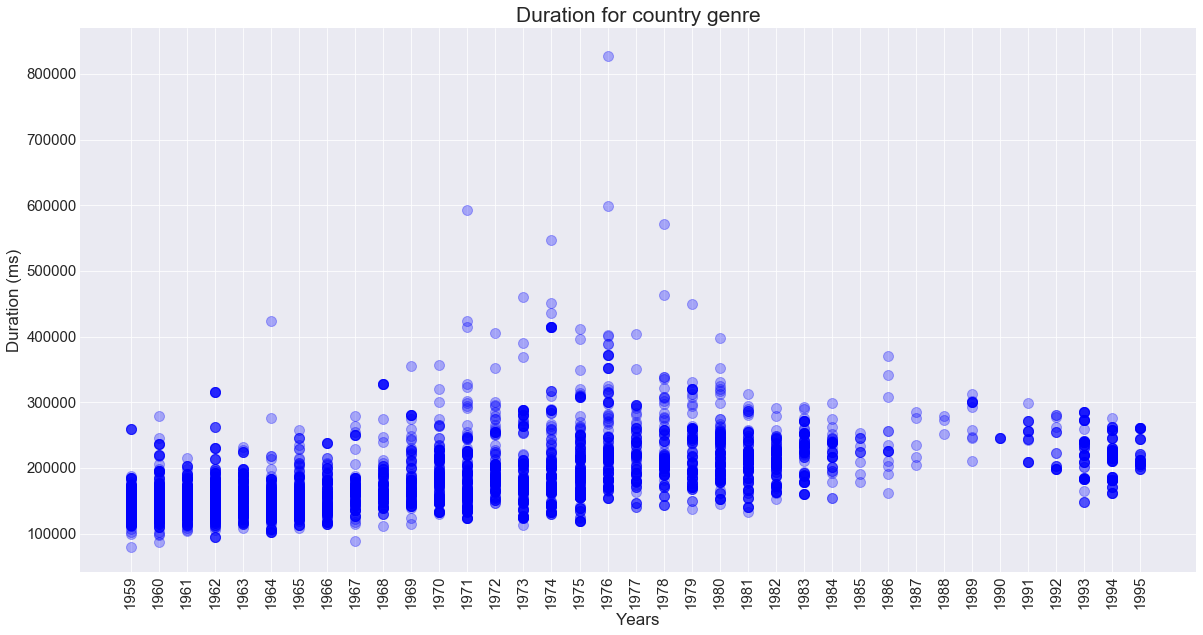

In [21]:
plot_scatter_plot(df_['year'], df_['country'], 'Duration for country genre', 'Duration (ms)', 'duration_country.png')

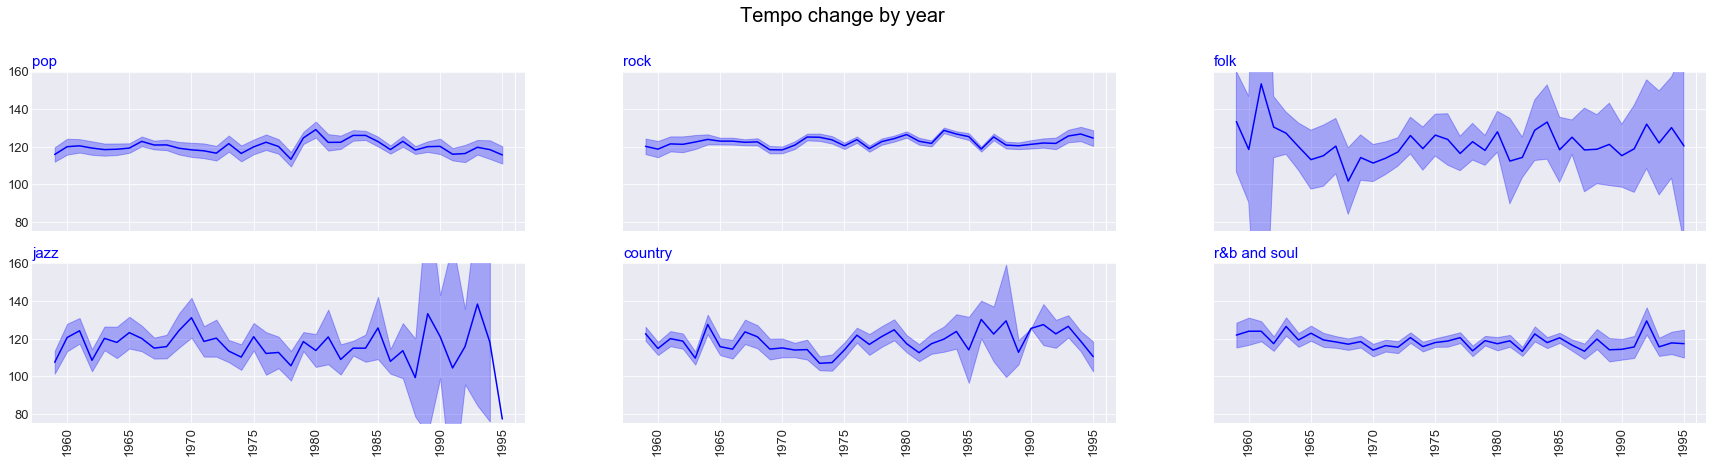

In [22]:
df_ = make_dataframe_per_genre('tempo')
plot_by_genre(df_, 'Tempo', 75, 160, 'tempo_by_genre.png')

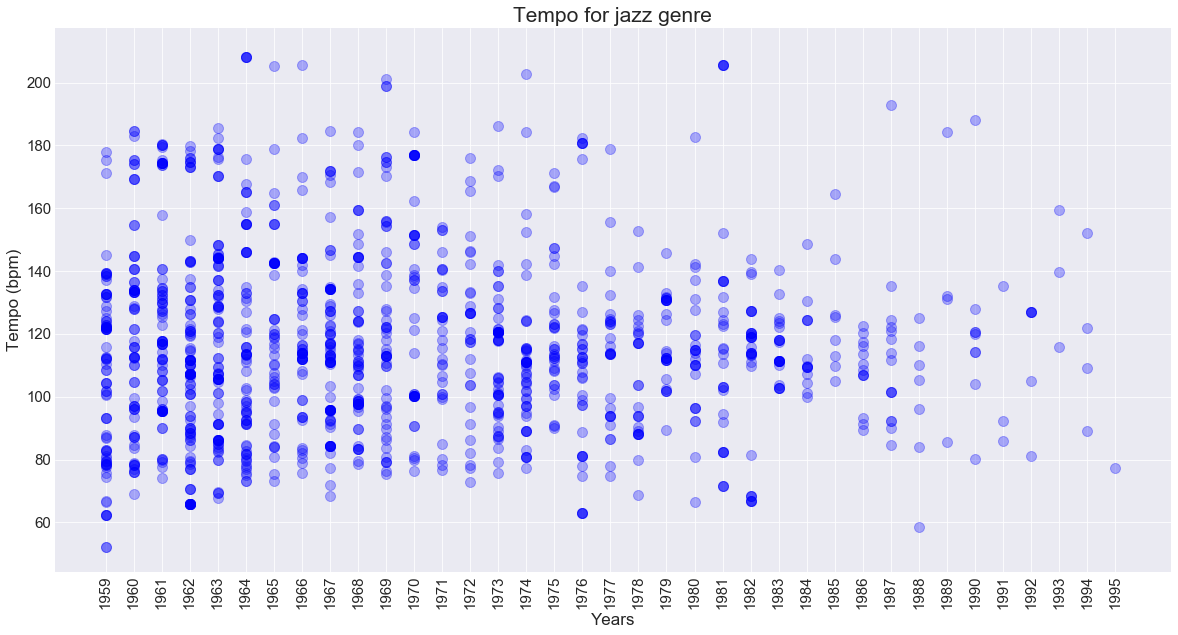

In [23]:
plot_scatter_plot(df_['year'], df_['jazz'], 'Tempo for jazz genre', 'Tempo (bpm)', 'tempo_jazz.png')

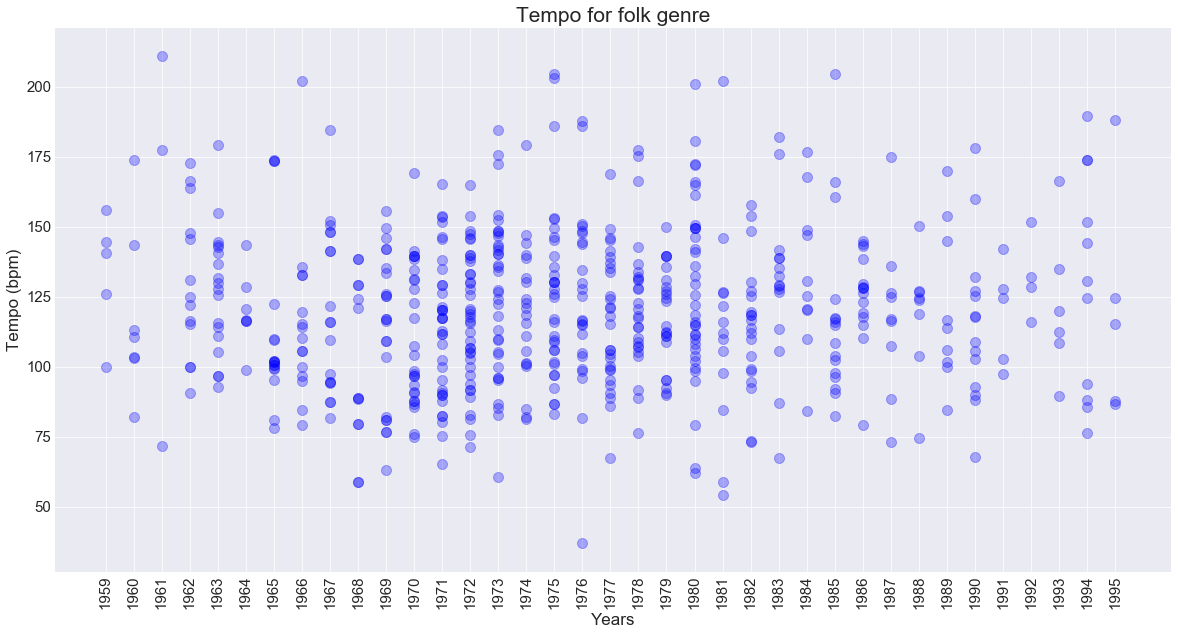

In [24]:
plot_scatter_plot(df_['year'], df_['folk'], 'Tempo for folk genre', 'Tempo (bpm)', 'tempo_folk.png')

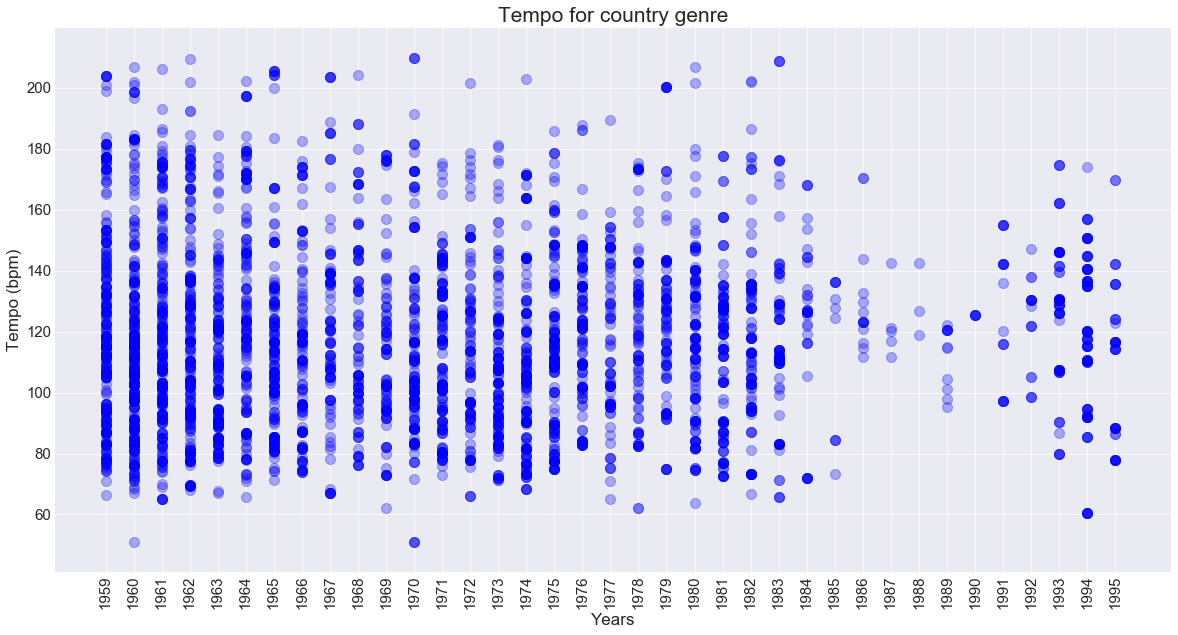

In [25]:
plot_scatter_plot(df_['year'], df_['country'], 'Tempo for country genre', 'Tempo (bpm)', 'tempo_country.png')

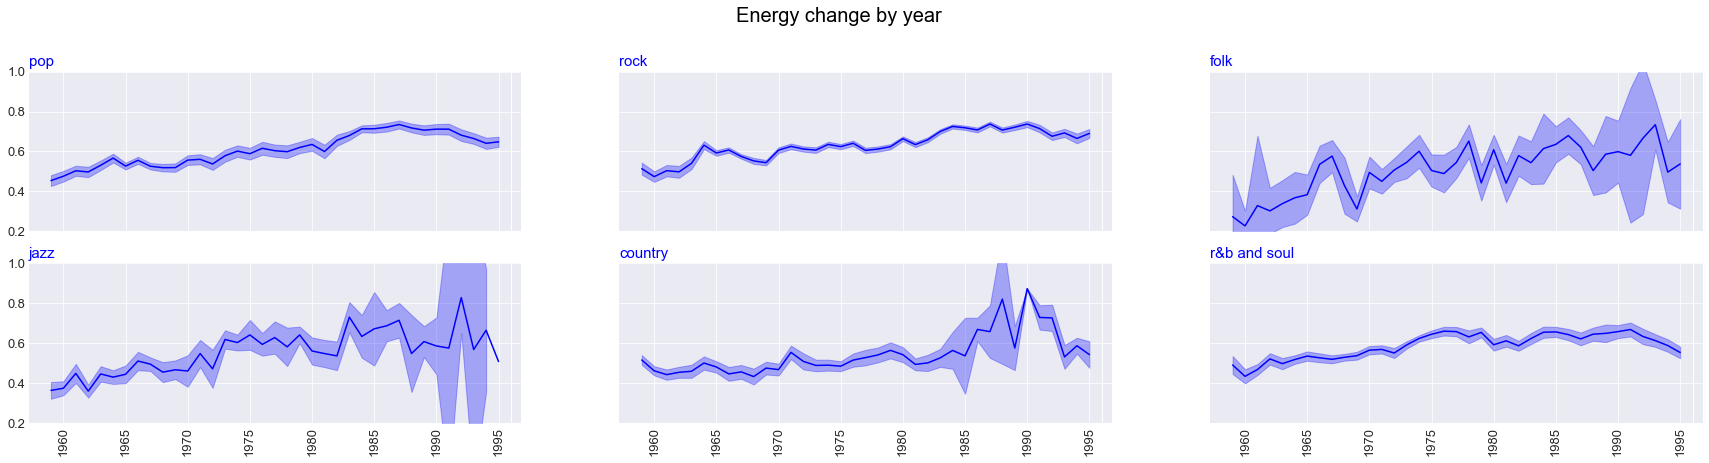

In [26]:
df_ = make_dataframe_per_genre('energy')
plot_by_genre(df_, 'Energy', 0.2, 1, 'energy_by_genre.png')

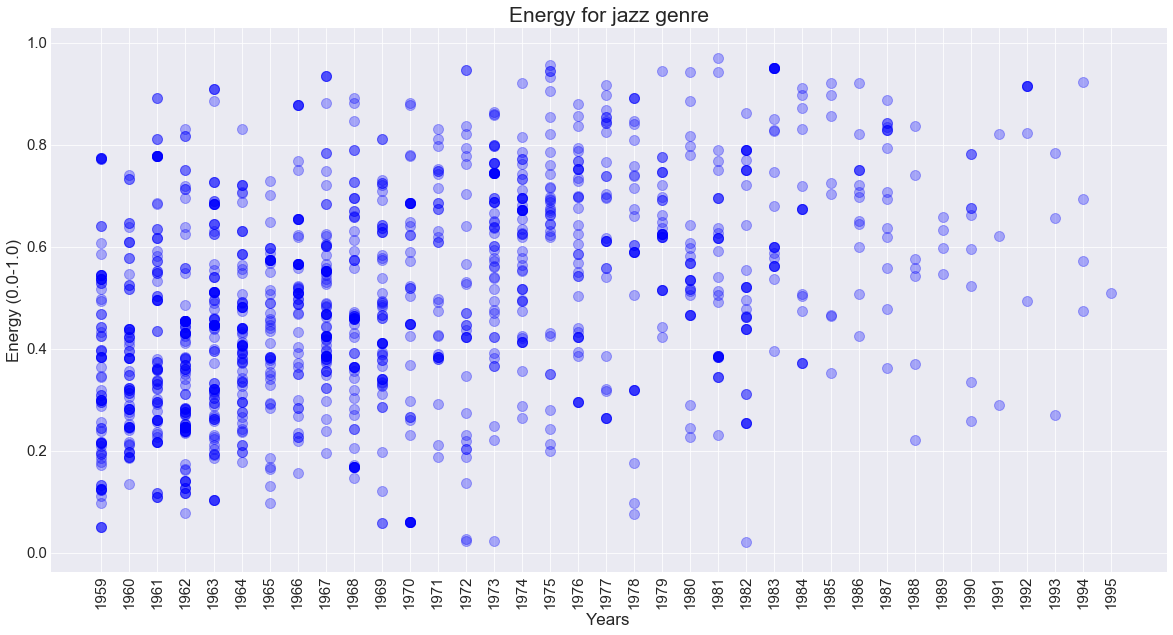

In [27]:
plot_scatter_plot(df_['year'], df_['jazz'], 'Energy for jazz genre', 'Energy (0.0-1.0)', 'energy_jazz.png')

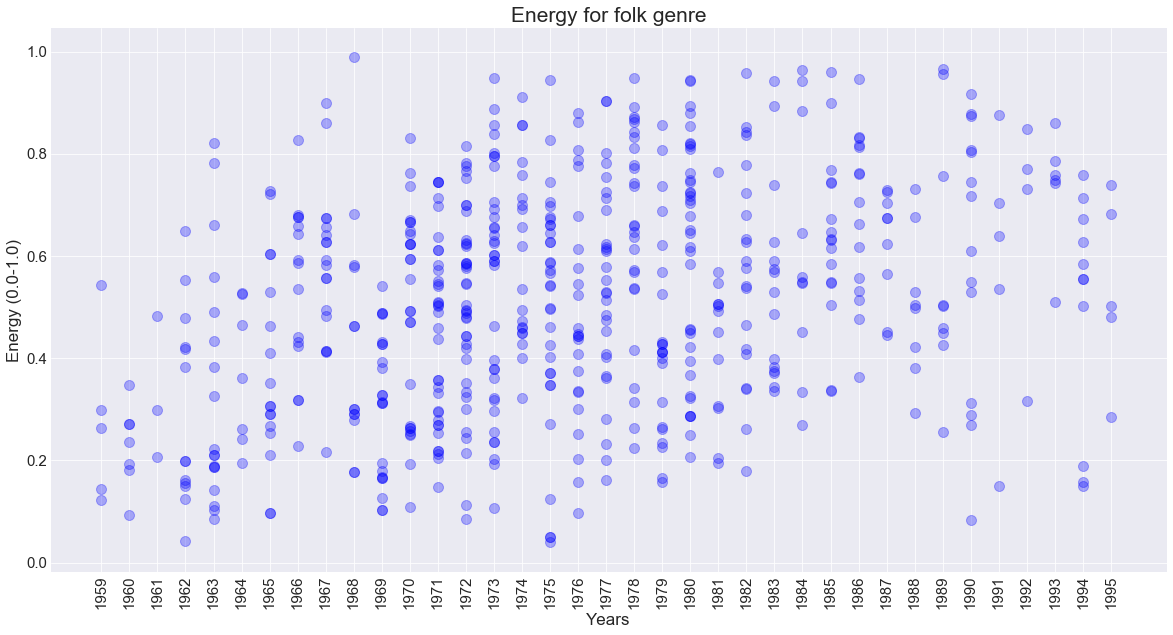

In [28]:
plot_scatter_plot(df_['year'], df_['folk'], 'Energy for folk genre', 'Energy (0.0-1.0)', 'energy_folk.png')

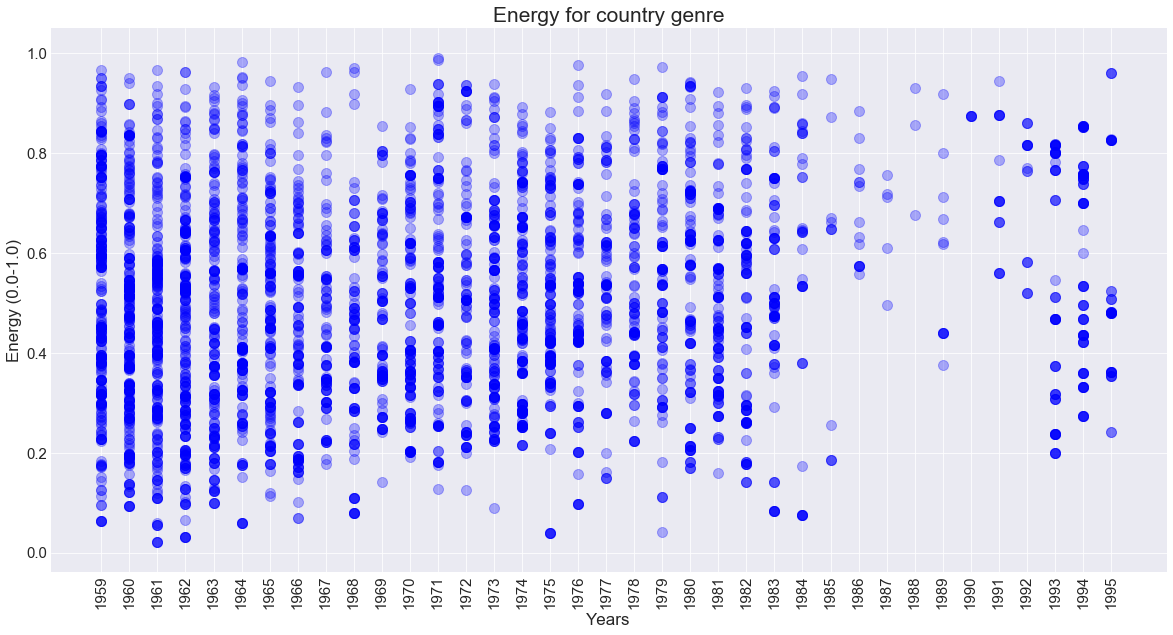

In [29]:
plot_scatter_plot(df_['year'], df_['country'], 'Energy for country genre', 'Energy (0.0-1.0)', 'energy_country.png')

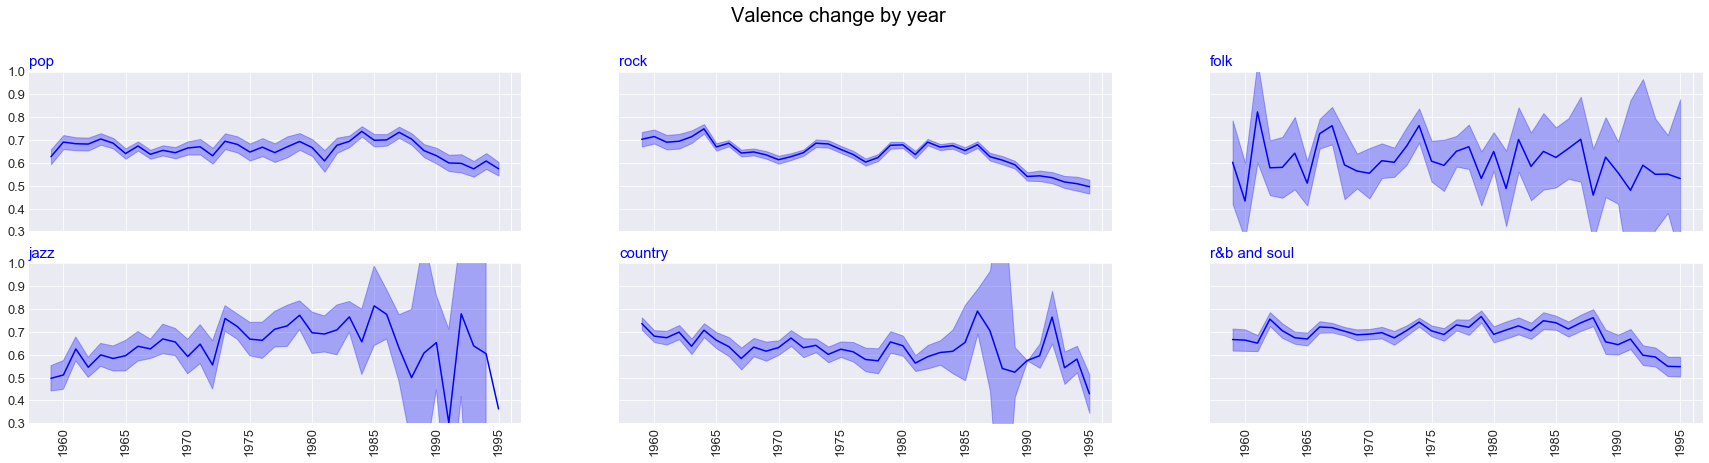

In [30]:
df_ = make_dataframe_per_genre('valence')
plot_by_genre(df_, 'Valence', 0.3, 1, 'valence_by_genre.png')

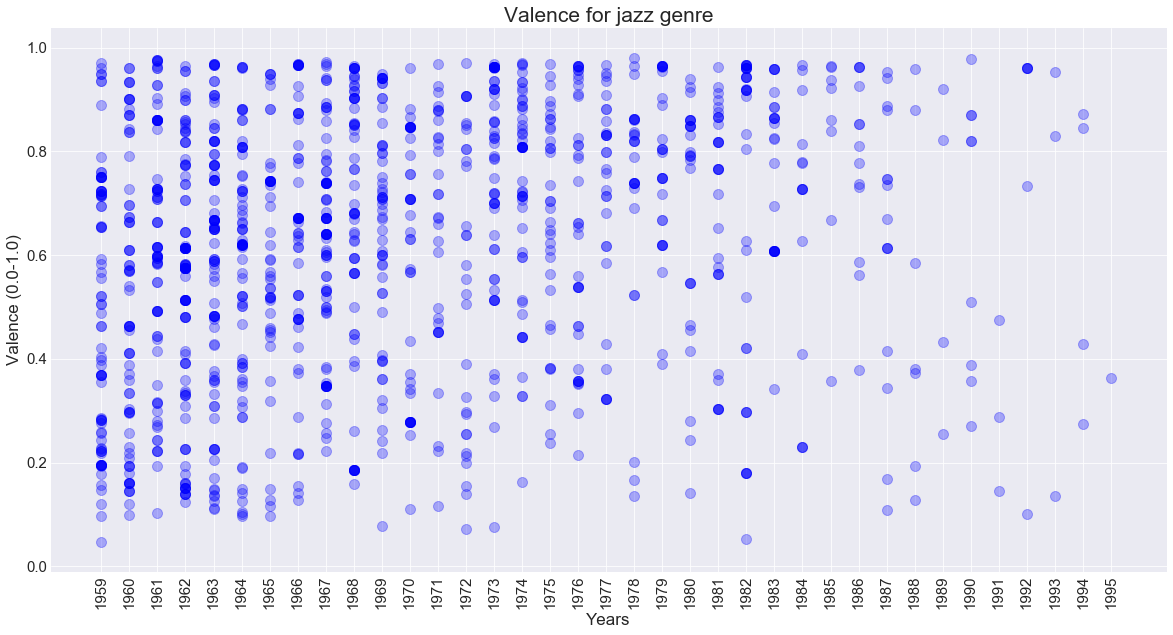

In [31]:
plot_scatter_plot(df_['year'], df_['jazz'], 'Valence for jazz genre', 'Valence (0.0-1.0)', 'valence_jazz.png')

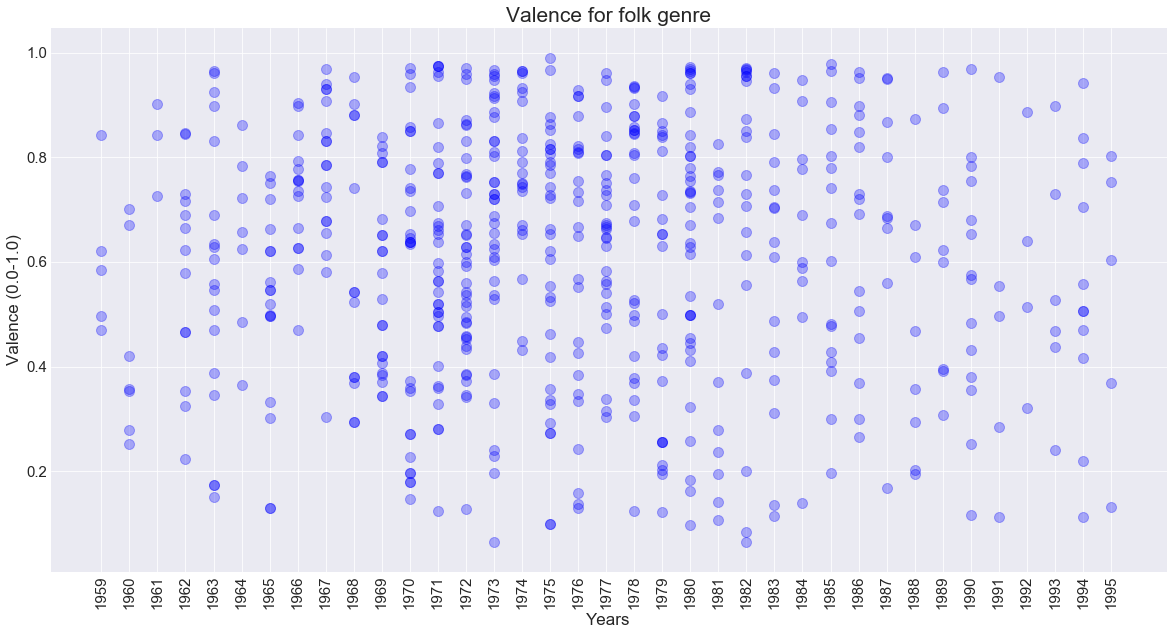

In [32]:
plot_scatter_plot(df_['year'], df_['folk'], 'Valence for folk genre', 'Valence (0.0-1.0)', 'valence_folk.png')

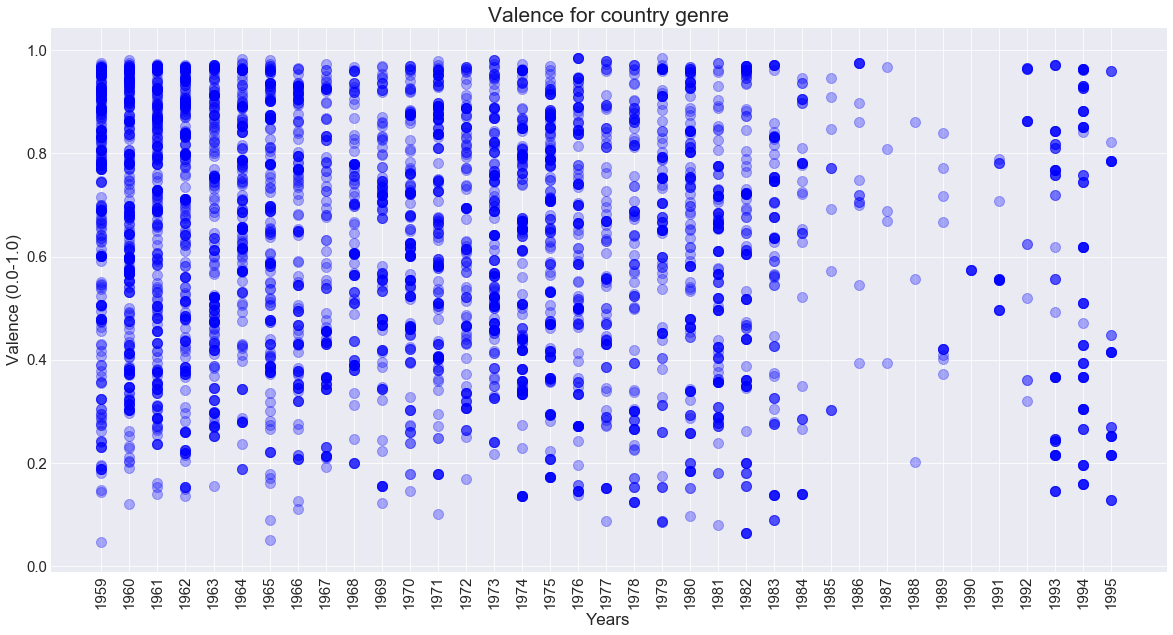

In [33]:
plot_scatter_plot(df_['year'], df_['country'], 'Valence for country genre', 'Valence (0.0-1.0)', 'valence_country.png')

# Discrete features by genre

## Mode by genre

In [34]:
feature = 'mode'
df_m = pd.DataFrame(columns=genres)
for genre in genres:
    df = dataset_genre.loc[dataset_genre['main_genre'] == genre]
    feature_per_genre = []
    for year in years2:
        df2 = df.loc[df['year'] == int(year)]
        temp = df2.loc[:, feature]
        if(len(temp) > 0):
            a = list(filter(lambda x: x!= -1, temp.tolist()))
            counter = Counter(a)
            dict_ = dict(sorted(counter.items()))
            if 0 not in dict_.keys():
                dict_.update({0:0})
            if 1 not in dict_.keys():
                dict_.update({1:0})
            dict_ = dict(sorted(dict_.items()))
            feature_per_genre.append(dict_)
        else:
            feature_per_genre.append({})      
    df_m[genre] = feature_per_genre
df_m['year'] = years2

In [35]:
df_m.head(5)

,pop,rock,folk,jazz,country,r&b and soul,year
0,"{0: 39, 1: 202}","{0: 28, 1: 190}","{0: 0, 1: 5}","{0: 19, 1: 65}","{0: 40, 1: 256}","{0: 13, 1: 77}",1959
1,"{0: 43, 1: 194}","{0: 40, 1: 176}","{0: 3, 1: 4}","{0: 9, 1: 64}","{0: 38, 1: 262}","{0: 12, 1: 81}",1960
2,"{0: 34, 1: 240}","{0: 26, 1: 192}","{0: 0, 1: 3}","{0: 32, 1: 47}","{0: 19, 1: 224}","{0: 37, 1: 115}",1961
3,"{0: 44, 1: 233}","{0: 34, 1: 184}","{0: 1, 1: 12}","{0: 20, 1: 87}","{0: 16, 1: 226}","{0: 21, 1: 153}",1962
4,"{0: 35, 1: 268}","{0: 16, 1: 206}","{0: 0, 1: 18}","{0: 9, 1: 85}","{0: 16, 1: 166}","{0: 32, 1: 155}",1963


Text(0.5, 0.97, 'Mode change by year')

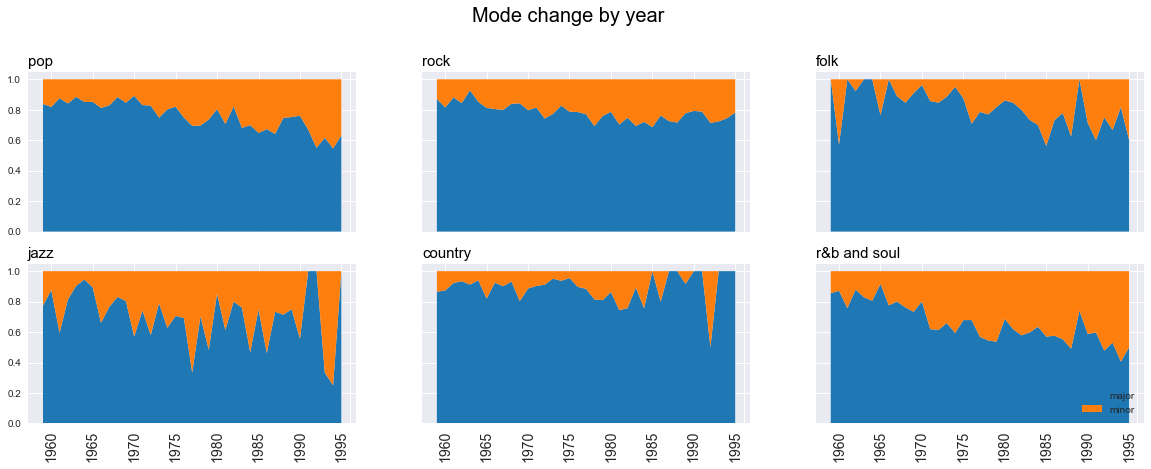

In [36]:
# Initialize the figure
plt.style.use('seaborn-notebook')
plt.figure(figsize=(20, 10))
 
# Color of title for genre
color = 'black'
 
# Multiple line plot
num=0
for column in df_m.drop('year', axis=1):
    num+=1
 
    # Find the right spot on the plot
    plt.subplot(3,3, num)
 
    # Plot the lineplot
    list_of_list = []

    for counter in df_m[column]:
        row = []
        for key, value in counter.items():
            row.append(value)
        list_of_list.append(row)
 
    # We need to transform the data from raw data to percentage (fraction)
    data = pd.DataFrame(data=list_of_list)
    data_perc = data.divide(data.sum(axis=1), axis=0)
    
    
    if num in range(6):
        plt.stackplot(df_m['year'],  data_perc.iloc[:,1], data_perc.iloc[:,0])
    else:
        plt.stackplot(df_m['year'],  data_perc.iloc[:,1], data_perc.iloc[:,0], labels=['major','minor'])
        plt.legend(loc='lower right')

 
        # Not ticks everywhere
    if num in range(4) :
        plt.tick_params(labelbottom='off')
    if num not in [1,4] :
        plt.tick_params(labelleft='off')
            
    years = []
    for y in df_m['year']:
        if int(y)%5 == 0:
            years.append(y)
        else:
            years.append(' ')  
    plt.xticks(years, rotation='vertical', fontsize=14)
        
 
        # Add title
    plt.title(column, loc='left', fontsize=15, color=color)
    
#General title
plt.suptitle("Mode change by year", fontsize=20, fontweight=0, color='black', y=0.97)
#plt.savefig('mode_by_genre.png')

## Time signature by genre

In [37]:
feature = 'time_signature'
df_t = pd.DataFrame(columns=genres)
for genre in genres:
    df = dataset_genre.loc[dataset_genre['main_genre'] == genre]
    feature_per_genre = []
    for year in years2:
        df2 = df.loc[df['year'] == int(year)]
        temp = df2.loc[:, feature]
        if(len(temp) > 0):
            a = list(filter(lambda x: x!= -1, temp.tolist()))
            counter = Counter(a)
            dict_ = dict(sorted(counter.items()))
            if 1 not in dict_.keys():
                dict_.update({1:0})
            if 2 not in dict_.keys():
                dict_.update({2:0})
            if 3 not in dict_.keys():
                dict_.update({3:0})
            if 4 not in dict_.keys():
                dict_.update({4:0})
            if 5 not in dict_.keys():
                dict_.update({5:0})
            dict_ = dict(sorted(dict_.items()))
            feature_per_genre.append(dict_)
        else:
            feature_per_genre.append({})      
    df_t[genre] = feature_per_genre
df_t['year'] = years2

In [38]:
df_t.head(5)

,pop,rock,folk,jazz,country,r&b and soul,year
0,"{1: 2, 2: 0, 3: 63, 4: 172, 5: 4}","{1: 1, 2: 0, 3: 35, 4: 179, 5: 3}","{1: 0, 2: 0, 3: 0, 4: 5, 5: 0}","{1: 3, 2: 0, 3: 19, 4: 58, 5: 4}","{1: 0, 2: 0, 3: 45, 4: 249, 5: 2}","{1: 0, 2: 0, 3: 23, 4: 65, 5: 2}",1959
1,"{1: 2, 2: 0, 3: 34, 4: 200, 5: 1}","{1: 1, 2: 0, 3: 21, 4: 193, 5: 1}","{1: 1, 2: 0, 3: 1, 4: 5, 5: 0}","{1: 5, 2: 0, 3: 14, 4: 54, 5: 0}","{1: 10, 2: 0, 3: 38, 4: 251, 5: 1}","{1: 2, 2: 0, 3: 23, 4: 68, 5: 0}",1960
2,"{1: 2, 2: 0, 3: 51, 4: 220, 5: 1}","{1: 1, 2: 0, 3: 39, 4: 178, 5: 0}","{1: 0, 2: 0, 3: 0, 4: 3, 5: 0}","{1: 1, 2: 0, 3: 13, 4: 60, 5: 5}","{1: 1, 2: 0, 3: 48, 4: 194, 5: 0}","{1: 3, 2: 0, 3: 41, 4: 108, 5: 0}",1961
3,"{1: 0, 2: 0, 3: 32, 4: 245, 5: 0}","{1: 0, 2: 0, 3: 21, 4: 197, 5: 0}","{1: 0, 2: 0, 3: 1, 4: 12, 5: 0}","{1: 0, 2: 0, 3: 37, 4: 70, 5: 0}","{1: 0, 2: 0, 3: 49, 4: 193, 5: 0}","{1: 2, 2: 0, 3: 24, 4: 148, 5: 0}",1962
4,"{1: 5, 2: 0, 3: 40, 4: 258, 5: 0}","{1: 6, 2: 0, 3: 31, 4: 185, 5: 0}","{1: 0, 2: 0, 3: 2, 4: 15, 5: 1}","{1: 1, 2: 0, 3: 9, 4: 81, 5: 3}","{1: 1, 2: 0, 3: 24, 4: 157, 5: 0}","{1: 2, 2: 0, 3: 51, 4: 134, 5: 0}",1963


Text(0.5, 0.97, 'Time signature change by year')

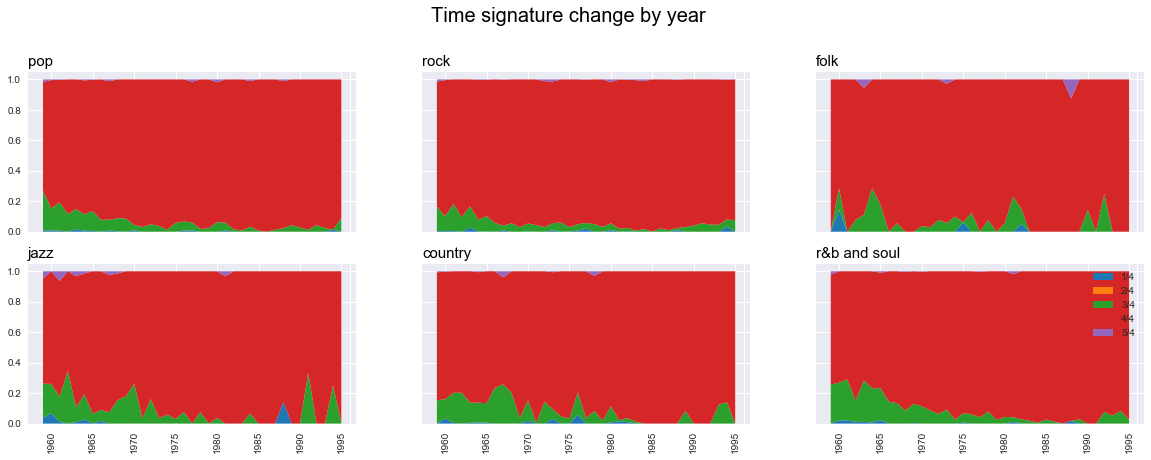

In [39]:
# Initialize the figure
plt.style.use('seaborn-notebook')
plt.figure(figsize=(20, 10))
 
# Color of title for genre
color = 'black'
 
# Multiple line plot
num=0
for column in df_t.drop('year', axis=1):
    num+=1
 
    # Find the right spot on the plot
    plt.subplot(3,3, num)
 
    # Plot the lineplot
    list_of_list = []

    for counter in df_t[column]:
        row = []
        for key, value in counter.items():
            row.append(value)
        list_of_list.append(row)
 
    # We need to transform the data from raw data to percentage (fraction)
    data = pd.DataFrame(data=list_of_list)
    data_perc = data.divide(data.sum(axis=1), axis=0)
    
    
    if num in range(6):
        plt.stackplot(df_t['year'], data_perc.iloc[:,0], data_perc.iloc[:,1], data_perc.iloc[:,2], data_perc.iloc[:,3], data_perc.iloc[:,4])
    else:
        plt.stackplot(df_t['year'],  data_perc.iloc[:,0], data_perc.iloc[:,1], data_perc.iloc[:,2], data_perc.iloc[:,3], data_perc.iloc[:,4], labels=['1/4','2/4', '3/4', '4/4', '5/4'])
        plt.legend(loc='upper right')

 
        # Not ticks everywhere
    if num in range(4) :
        plt.tick_params(labelbottom='off')
    if num not in [1,4] :
        plt.tick_params(labelleft='off')
            
    years = []
    for y in df_t['year']:
        if int(y)%5 == 0:
            years.append(y)
        else:
            years.append(' ')  
    plt.xticks(years, rotation='vertical')
        
 
        # Add title
    plt.title(column, loc='left', fontsize=15, color=color)

#General title
plt.suptitle("Time signature change by year", fontsize=20, fontweight=0, color='black', y=0.97)
#plt.savefig('time_signature_by_year.png')

## Root by genre

In [40]:
feature = 'key'
df_r = pd.DataFrame(columns=genres)
for genre in genres:
    df = dataset_genre.loc[dataset_genre['main_genre'] == genre]
    feature_per_genre = []
    for year in years2:
        df2 = df.loc[df['year'] == int(year)]
        temp = df2.loc[:, feature]
        if(len(temp) > 0):
            a = list(filter(lambda x: x!= -1, temp.tolist()))
            counter = Counter(a)
            dict_ = dict(sorted(counter.items()))
            if 0 not in dict_.keys():
                dict_.update({0:0})
            if 1 not in dict_.keys():
                dict_.update({1:0})
            if 2 not in dict_.keys():
                dict_.update({2:0})
            if 3 not in dict_.keys():
                dict_.update({3:0})
            if 4 not in dict_.keys():
                dict_.update({4:0})
            if 5 not in dict_.keys():
                dict_.update({5:0})
            if 6 not in dict_.keys():
                dict_.update({6:0})
            if 7 not in dict_.keys():
                dict_.update({7:0})
            if 8 not in dict_.keys():
                dict_.update({8:0})
            if 9 not in dict_.keys():
                dict_.update({9:0})
            if 10 not in dict_.keys():
                dict_.update({10:0})
            if 11 not in dict_.keys():
                dict_.update({11:0})
            dict_ = dict(sorted(dict_.items()))
            feature_per_genre.append(dict_)
        else:
            feature_per_genre.append({})      
    df_r[genre] = feature_per_genre
df_r['year'] = years2

In [41]:
df_r.head()

,pop,rock,folk,jazz,country,r&b and soul,year
0,"{0: 41, 1: 10, 2: 21, 3: 17, 4: 20, 5: 24, 6: ...","{0: 41, 1: 10, 2: 13, 3: 17, 4: 19, 5: 19, 6: ...","{0: 0, 1: 0, 2: 1, 3: 0, 4: 1, 5: 0, 6: 1, 7: ...","{0: 13, 1: 3, 2: 5, 3: 12, 4: 4, 5: 9, 6: 2, 7...","{0: 50, 1: 5, 2: 25, 3: 14, 4: 26, 5: 27, 6: 5...","{0: 12, 1: 7, 2: 6, 3: 6, 4: 7, 5: 10, 6: 2, 7...",1959
1,"{0: 32, 1: 14, 2: 17, 3: 8, 4: 27, 5: 32, 6: 8...","{0: 31, 1: 11, 2: 14, 3: 6, 4: 21, 5: 40, 6: 7...","{0: 0, 1: 0, 2: 2, 3: 0, 4: 1, 5: 2, 6: 0, 7: ...","{0: 12, 1: 4, 2: 4, 3: 4, 4: 3, 5: 12, 6: 8, 7...","{0: 57, 1: 16, 2: 18, 3: 22, 4: 29, 5: 37, 6: ...","{0: 8, 1: 4, 2: 6, 3: 7, 4: 3, 5: 17, 6: 4, 7:...",1960
2,"{0: 40, 1: 27, 2: 33, 3: 7, 4: 21, 5: 30, 6: 5...","{0: 39, 1: 22, 2: 23, 3: 4, 4: 10, 5: 23, 6: 4...","{0: 2, 1: 1, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: ...","{0: 13, 1: 7, 2: 1, 3: 3, 4: 4, 5: 7, 6: 0, 7:...","{0: 49, 1: 13, 2: 31, 3: 16, 4: 14, 5: 18, 6: ...","{0: 31, 1: 11, 2: 11, 3: 4, 4: 9, 5: 22, 6: 2,...",1961
3,"{0: 34, 1: 15, 2: 25, 3: 19, 4: 18, 5: 31, 6: ...","{0: 25, 1: 11, 2: 13, 3: 20, 4: 14, 5: 23, 6: ...","{0: 3, 1: 0, 2: 1, 3: 1, 4: 2, 5: 0, 6: 1, 7: ...","{0: 13, 1: 3, 2: 1, 3: 2, 4: 5, 5: 37, 6: 1, 7...","{0: 33, 1: 12, 2: 38, 3: 8, 4: 25, 5: 22, 6: 8...","{0: 24, 1: 22, 2: 16, 3: 18, 4: 5, 5: 18, 6: 5...",1962
4,"{0: 53, 1: 23, 2: 23, 3: 20, 4: 25, 5: 46, 6: ...","{0: 33, 1: 13, 2: 26, 3: 15, 4: 14, 5: 28, 6: ...","{0: 0, 1: 0, 2: 1, 3: 1, 4: 3, 5: 5, 6: 0, 7: ...","{0: 14, 1: 9, 2: 1, 3: 2, 4: 6, 5: 26, 6: 1, 7...","{0: 30, 1: 14, 2: 6, 3: 9, 4: 11, 5: 30, 6: 3,...","{0: 29, 1: 11, 2: 9, 3: 24, 4: 6, 5: 24, 6: 4,...",1963


Text(0.5, 0.97, 'Root change by year')

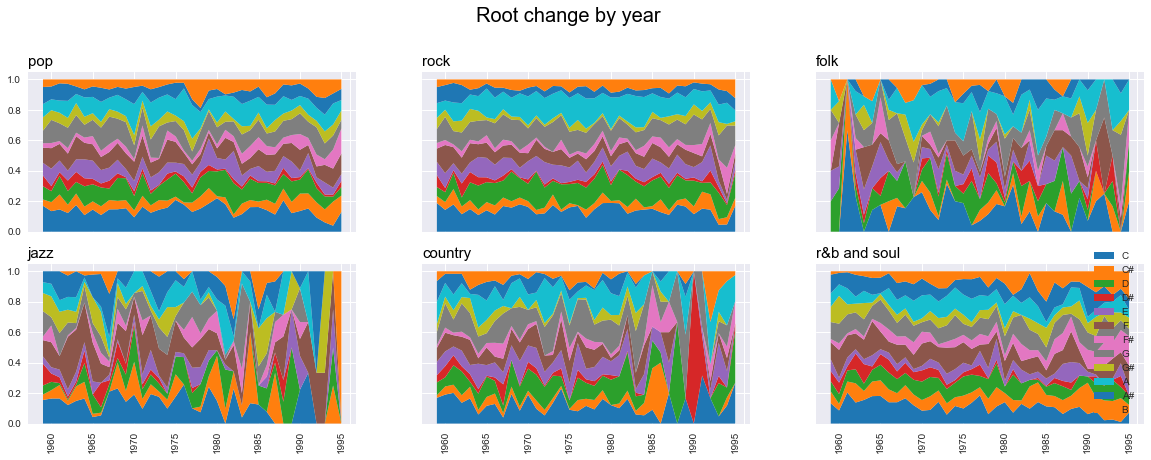

In [42]:
# Initialize the figure
plt.style.use('seaborn-notebook')
plt.figure(figsize=(20, 10))
 
# Color of title for genre
color = 'black'
 
# Multiple line plot
num=0
for column in df_r.drop('year', axis=1):
    num+=1
 
    # Find the right spot on the plot
    plt.subplot(3,3, num)
 
    # Plot the lineplot
    list_of_list = []

    for counter in df_r[column]:
        row = []
        for key, value in counter.items():
            row.append(value)
        list_of_list.append(row)
 
    # We need to transform the data from raw data to percentage (fraction)
    data = pd.DataFrame(data=list_of_list)
    data_perc = data.divide(data.sum(axis=1), axis=0)
    
    
    if num in range(6):
        plt.stackplot(df_r['year'], data_perc.iloc[:,0], data_perc.iloc[:,1], data_perc.iloc[:,2], data_perc.iloc[:,3], data_perc.iloc[:,4], data_perc.iloc[:,5], data_perc.iloc[:,6], data_perc.iloc[:,7], data_perc.iloc[:,8], data_perc.iloc[:,9], data_perc.iloc[:,10], data_perc.iloc[:,11])
    else:
        plt.stackplot(df_r['year'],  data_perc.iloc[:,0], data_perc.iloc[:,1], data_perc.iloc[:,2], data_perc.iloc[:,3], data_perc.iloc[:,4], data_perc.iloc[:,5], data_perc.iloc[:,6], data_perc.iloc[:,7], data_perc.iloc[:,8], data_perc.iloc[:,9], data_perc.iloc[:,10], data_perc.iloc[:,11], labels=['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B'])
        plt.legend(loc='lower right')

 
        # Not ticks everywhere
    if num in range(4) :
        plt.tick_params(labelbottom='off')
    if num not in [1,4] :
        plt.tick_params(labelleft='off')
            
    years = []
    for y in df_r['year']:
        if int(y)%5 == 0:
            years.append(y)
        else:
            years.append(' ')  
    plt.xticks(years, rotation='vertical')
        
 
        # Add title
    plt.title(column, loc='left', fontsize=15, color=color)
    
# Same limits for everybody!
#plt.xlim(1900, 2000)
#print(mean, max_, min_)
    #plt.ylim(min_, max_)

#General title
plt.suptitle("Root change by year", fontsize=20, fontweight=0, color='black', y=0.97)
#plt.savefig('root_by_year.png')